## Import Necessary Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import heapq

## Load Dataset and Handle Missing Values

In [21]:
df = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
df.fillna(method='ffill', inplace=True)

<ipython-input-21-4a95373a40d3>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## Filter Data for a Specific Store and Product Family

In [22]:
df_store = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')]

## Resample to Monthly Data for Demand Forecasting

In [23]:
df_store = df_store['sales'].resample('M').sum()

## Outlier Detection using Z-Score

In [24]:
z_scores = (df_store - df_store.mean()) / df_store.std()
df_store_cleaned = df_store[(z_scores.abs() < 3)]

## Add Time-Related Features

In [25]:
df_store_cleaned = pd.DataFrame(df_store_cleaned)
df_store_cleaned['month'] = df_store_cleaned.index.month
df_store_cleaned['year'] = df_store_cleaned.index.year

## Scaling Data

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_store_cleaned['sales'].values.reshape(-1, 1))

## Creating a Sliding Window Function for Time Steps

In [27]:
def create_dataset(dataset, time_step=12):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


## Split Data into Train and Test Sets

In [28]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

## Reshape Data to [samples, time steps, features] for LSTM input

In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Define LSTM Model

In [30]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - loss: 0.2433 - val_loss: 0.5166
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2272 - val_loss: 0.4832
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2020 - val_loss: 0.4497
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1886 - val_loss: 0.4156
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1707 - val_loss: 0.3808
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1448 - val_loss: 0.3449
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1315 - val_loss: 0.3082
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1091 - val_loss: 0.2705
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0921 - val_loss: 0.2325
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0751 - val_loss: 0.1946
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0551 - val_loss: 0.1577
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0423 - val_loss: 0.1229


## Make Predictions

In [31]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


## Inverse Transform Predictions and Actual Values to Original Scale

In [32]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

## Calculate MSE

In [33]:
train_mse = mean_squared_error(y_train_inv[0], train_predict)
test_mse = mean_squared_error(y_test_inv[0], test_predict)
print(f'Train Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')

Train Mean Squared Error: 57390973.79576837
Test Mean Squared Error: 174114857.57269898


## Plot the Results

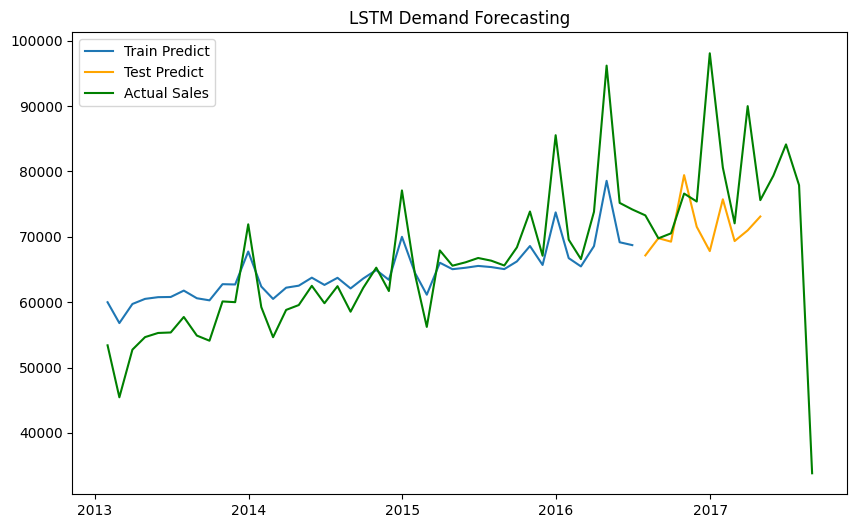

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df_store_cleaned.index[:len(train_predict)], train_predict, label='Train Predict')
plt.plot(df_store_cleaned.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict, label='Test Predict', color='orange')
plt.plot(df_store_cleaned.index, df_store_cleaned['sales'], label='Actual Sales', color='green')
plt.legend()
plt.title('LSTM Demand Forecasting')
plt.show()

## Inventory Optimization using Economic Order Quantity (EOQ)

In [36]:
def calculate_eoq(demand, ordering_cost, holding_cost):
    return np.sqrt((2 * demand * ordering_cost) / holding_cost)

# Example parameters for EOQ calculation
ordering_cost = 50  # Cost per order
holding_cost = 2    # Cost per unit held in inventory per period

# Calculate EOQ based on forecasted monthly demand
monthly_demand = np.mean(test_predict)  # Average demand from forecasted values
eoq = calculate_eoq(monthly_demand, ordering_cost, holding_cost)
print(f'Optimal Order Quantity (EOQ): {eoq}')

Optimal Order Quantity (EOQ): 1889.661221290737


## Logistics Optimization : Simple Cost Function

In [37]:
def logistics_cost(demand, transport_cost_per_unit, holding_cost_per_unit):
    holding_cost_total = holding_cost_per_unit * np.mean(demand)  # Total holding cost
    transport_cost_total = transport_cost_per_unit * np.sum(demand)  # Total transportation cost
    return holding_cost_total + transport_cost_total

# Example parameters for logistics cost calculation
transport_cost_per_unit = 5  # Cost to transport one unit

# Calculate logistics cost based on forecasted demand
total_logistics_cost = logistics_cost(test_predict, transport_cost_per_unit, holding_cost)
print(f'Total Logistics Cost: {total_logistics_cost}')


Total Logistics Cost: 3713652.15625


## Logistics Optimization: Shortest Route

In [41]:
# Define the graph representing the logistics network (e.g., warehouses as nodes, routes as edges with weights)
graph = {
    'A': {'B': 2, 'C': 4},  # Warehouse A has routes to B (2 units of distance) and C (4 units of distance)
    'B': {'A': 2, 'C': 1, 'D': 7},  # Warehouse B has routes to A, C, and D
    'C': {'A': 4, 'B': 1, 'D': 3},  # Warehouse C has routes to A, B, and D
    'D': {'B': 7, 'C': 3}  # Warehouse D has routes to B and C
}

# Define the Dijkstra algorithm to calculate the shortest route from the starting node
def dijkstra(graph, start):
    queue = [(0, start)]  # Priority queue initialized with the starting node
    distances = {node: float('infinity') for node in graph}  # Initialize distances to infinity for all nodes
    distances[start] = 0  # Distance to the start node is 0
    while queue:
        current_distance, current_node = heapq.heappop(queue)  # Get node with the smallest distance
        # Skip if we've already found a shorter path
        if current_distance > distances[current_node]:
            continue
        # Loop through neighboring nodes and update their distances
        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            # Only consider this route if it's shorter than the currently known distance
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(queue, (distance, neighbor))  # Push the new shortest distance to the queue
    return distances

# Finding the shortest route starting from warehouse 'A'
distances = dijkstra(graph, 'A')

# Output the shortest routes from 'A' to other warehouses
print('Shortest Routes from A:', distances)

Shortest Routes from A: {'A': 0, 'B': 2, 'C': 3, 'D': 6}


## Conclusion

This notebook demonstrates a basic implementation of demand forecasting, inventory optimization, and logistics optimization using a retail dataset. The LSTM model forecasts demand, EOQ manages inventory, and Dijkstra's algorithm optimizes logistics.

This simplified example showcases the potential of these techniques for OptiChain. However, real-world applications require further development, including:

- Improved model accuracy: Refining parameters and incorporating more sophisticated algorithms.
- Real-time data integration: Enhancing operational effectiveness with dynamic data.
- Expanded scope: Including additional variables and constraints for a comprehensive supply chain optimization solution.